#Paper [9]
[Ensemble Learning for Improved Diabetes Classification.](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-023-05467-x)

In [3]:
# !pip install pyartemis
# !pip install artemis
# !pip install alibi

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE, plot_ale

In [5]:
df = pd.read_csv('/content/preprocessed_diabetes_data.csv')

In [6]:
X=df.drop('Diabetes_012',axis=1)
y=df['Diabetes_012']

In [7]:
y.value_counts()

,Diabetes_012
0.0,190055
1.0,39726


In [8]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

,Diabetes_012
0.0,190055
1.0,190055


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
# Pad and reshape features (assume 36 or fewer columns for 6x6 grid)
X_train_pad = np.pad(X_train, ((0,0), (0, 36 - X_train.shape[1])), mode='constant')
X_train_reshaped = X_train_pad.reshape(-1, 6, 6, 1)

# One-hot encode class labels
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(y_train.values.reshape(-1, 1))
num_classes = y_train_oh.shape[1]
latent_dim = 100


#Conditional GAN Model

In [12]:
def build_generator(latent_dim, num_classes):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(6*6*64, activation='relu')(x)
    x = layers.Reshape((6, 6, 64))(x)

    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, 3, padding='same', activation='tanh')(x)

    return Model([noise_input, label_input], x)

generator = build_generator(latent_dim, num_classes)


In [13]:
def build_discriminator(num_classes):
    img_input = layers.Input(shape=(6, 6, 1))
    label_input = layers.Input(shape=(num_classes,))

    label_map = layers.Dense(6*6)(label_input)
    label_map = layers.Reshape((6, 6, 1))(label_map)

    x = layers.Concatenate()([img_input, label_map])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return Model([img_input, label_input], x)

discriminator = build_discriminator(num_classes)


In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)


In [15]:
@tf.function
def train_step(real_imgs, real_labels):
    batch_size = tf.shape(real_imgs)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_imgs = generator([noise, real_labels], training=True)

        real_output = discriminator([real_imgs, real_labels], training=True)
        fake_output = discriminator([fake_imgs, real_labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))


In [16]:
EPOCHS = 5
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train_oh)).shuffle(1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    for real_batch, label_batch in train_ds:
        train_step(real_batch, label_batch)


In [17]:
num_gen = 5000
noise = tf.random.normal([num_gen, latent_dim])
labels = encoder.transform([[1]] * num_gen)

generated_imgs = generator.predict([noise, labels])
generated_flat = generated_imgs.reshape(num_gen, -1)[:, :X.shape[1]]  # crop padded zeros


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [18]:
generated_imgs

array([[[[ 9.99979198e-01],
         [ 9.99994993e-01],
         [ 2.72720158e-01],
         [ 9.99922395e-01],
         [-9.98527944e-01],
         [-7.01861009e-02]],

        [[-2.09909081e-01],
         [-9.99996245e-01],
         [-9.99994397e-01],
         [ 1.05533078e-01],
         [-3.20575107e-03],
         [ 2.63571851e-02]],

        [[ 2.27791984e-02],
         [ 9.99675512e-01],
         [ 9.99779940e-01],
         [ 9.99775350e-01],
         [ 1.77273173e-02],
         [-9.99638200e-01]],

        [[-9.98365939e-01],
         [-9.99899089e-01],
         [-9.98828411e-01],
         [ 6.60010055e-02],
         [ 3.35974712e-03],
         [ 1.85778476e-02]],

        [[-3.90554522e-03],
         [ 1.52759021e-03],
         [-1.12573067e-02],
         [-1.61157455e-02],
         [ 1.21785467e-02],
         [-1.73017252e-02]],

        [[ 6.54299511e-05],
         [-1.09106964e-02],
         [ 4.53322474e-03],
         [ 1.26926759e-02],
         [-3.03739565e-03],
         [

In [19]:
generated_flat

array([[ 0.9999792 ,  0.999995  ,  0.27272016, ..., -0.99836594,
        -0.9998991 , -0.9988284 ],
       [ 0.99995697,  0.9999916 ,  0.28717938, ..., -0.9986352 ,
        -0.99986684, -0.99810296],
       [ 0.9999775 ,  0.999997  ,  0.28679997, ..., -0.99913156,
        -0.99996716, -0.9991909 ],
       ...,
       [ 0.9999675 ,  0.99999434,  0.2756209 , ..., -0.99884284,
        -0.9998842 , -0.99823713],
       [ 0.99997723,  0.9999948 ,  0.26975244, ..., -0.9988542 ,
        -0.99988425, -0.9986038 ],
       [ 0.99997497,  0.99999493,  0.2819997 , ..., -0.99904937,
        -0.99990296, -0.9987129 ]], dtype=float32)

In [20]:
X_augmented = np.vstack([X_train, generated_flat])
y_augmented = np.concatenate([y_train, [1]*num_gen])



#XGBoost Model

In [21]:
# Train XGBoost on augmented dataset (real + synthetic)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_augmented, y_augmented)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:04:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# Evaluation
print(classification_report(y_test, y_pred_xgb))
# Get probabilities for the positive class only
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     37957
         1.0       0.96      0.83      0.89     38065

    accuracy                           0.89     76022
   macro avg       0.90      0.89      0.89     76022
weighted avg       0.90      0.89      0.89     76022

AUC: 0.9567256519412565


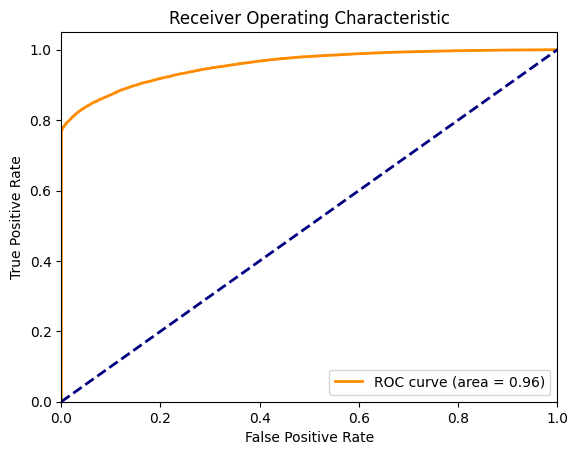

In [23]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


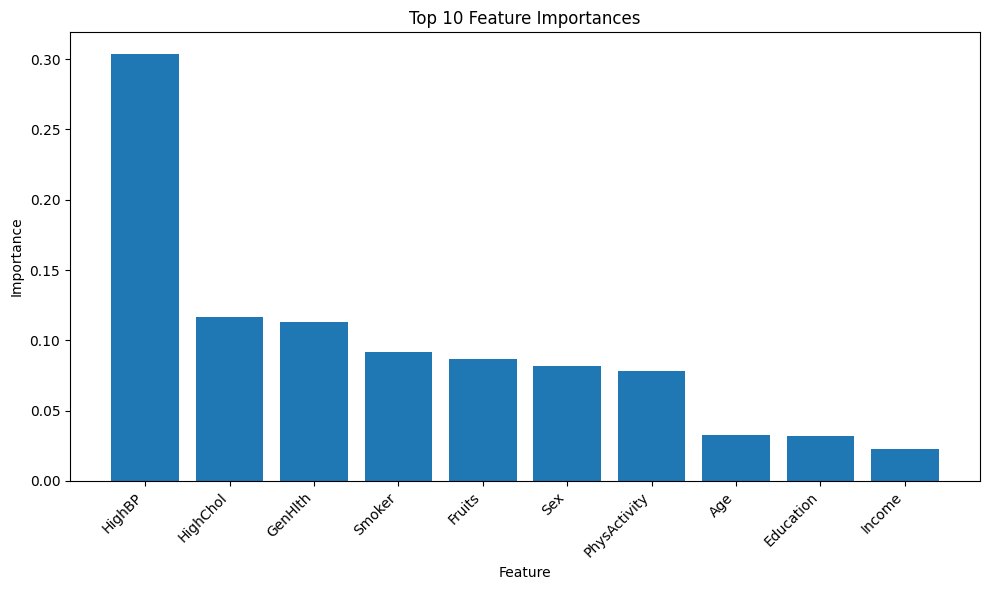

In [24]:
feature_names = X.columns

# Get feature importances from the model
importances = xgb_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

#Global Surrogate Model

In [25]:
blackbox_preds = xgb_model.predict(X_train)

surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, blackbox_preds)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [26]:
surrogate_preds = surrogate.predict(X_train)
fidelity = accuracy_score(blackbox_preds, surrogate_preds)
print(f"Fidelity (Accuracy vs XGBoost predictions): {fidelity:.4f}")

Fidelity (Accuracy vs XGBoost predictions): 0.7897


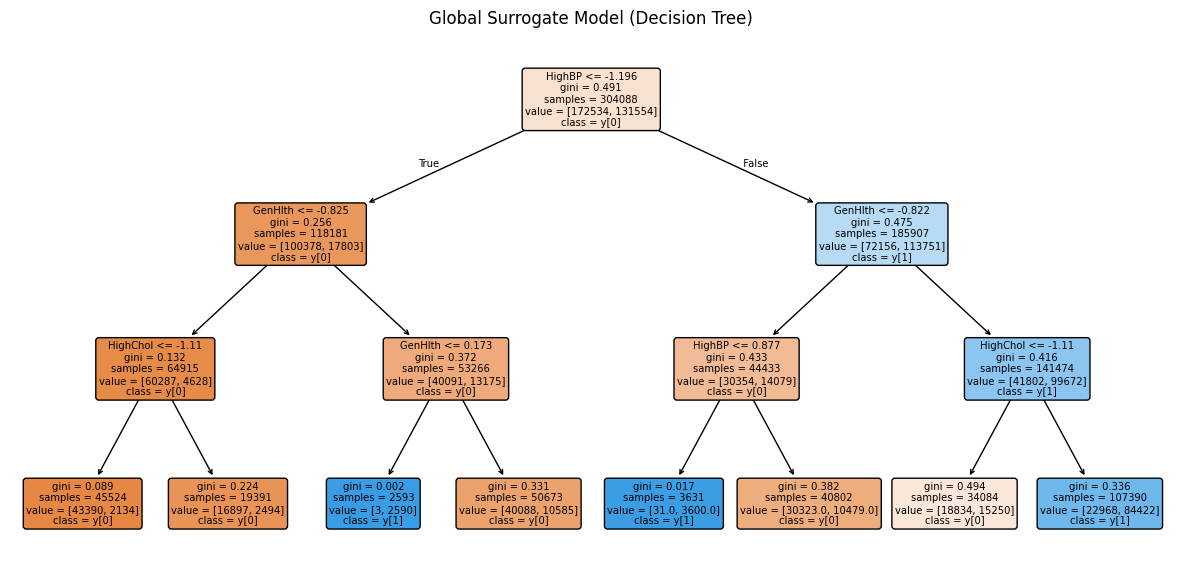

In [27]:
plt.figure(figsize=(15, 7))
plot_tree(surrogate, feature_names=X.columns, class_names=True, filled=True, rounded=True)
plt.title("Global Surrogate Model (Decision Tree)")
plt.show()

#H-Statistic (Feature Interaction)

In [28]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [29]:
# Get random selection of 100 observations
random.seed(8)
# Convert X_resampled to a list of rows for random.choices
X_exp = random.choices(X_resampled.to_numpy().tolist(), k=100)
X_exp = pd.DataFrame(X_exp, columns=X_resampled.columns)

# Calculate Friedman H statistic
h_stat = FriedmanHStatisticMethod()
h_stat.fit(xgb_model, X_exp)

/usr/local/lib/python3.11/dist-packages/artemis/interactions_methods/model_agnostic/partial_dependence_based/_friedman_h_statistic.py:226: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(nominator) / np.sum(denominator) if normalized else np.sqrt(np.mean(nominator))


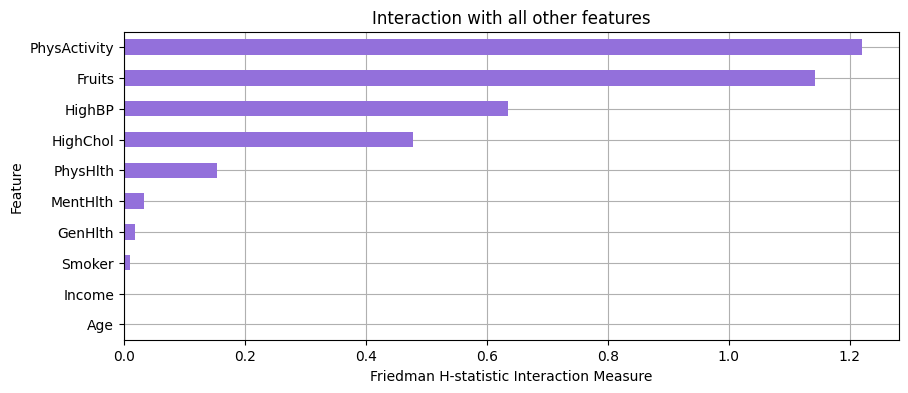

In [30]:
# Overall interaction plot
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

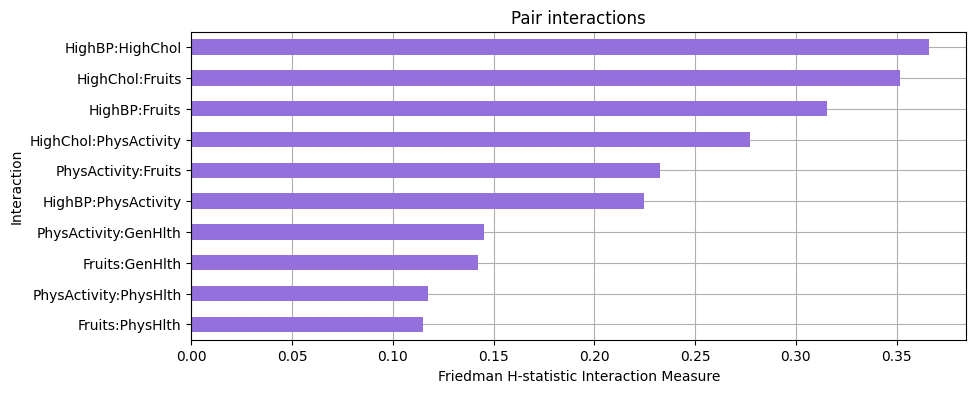

In [31]:
# Pairwise interactions
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)

#PDP

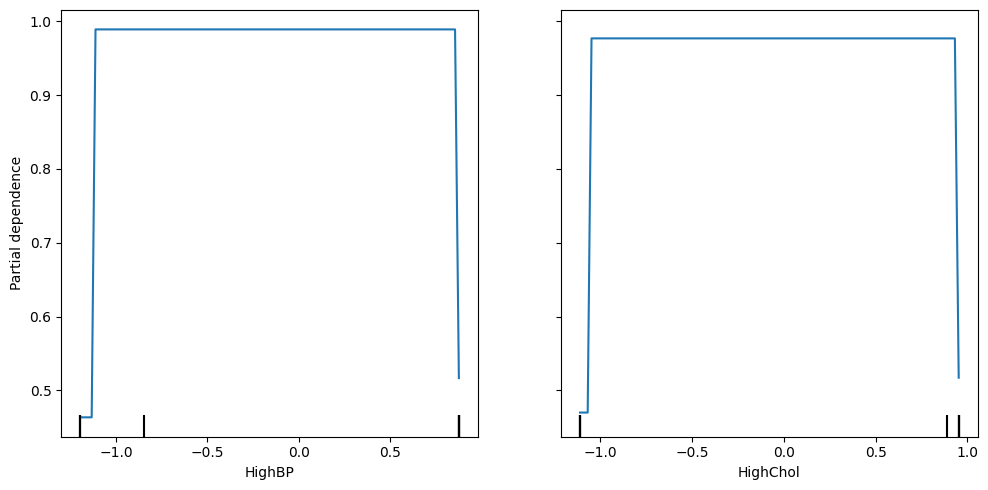

In [32]:
# Get list of feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"feature_{i}" for i in range(X.shape[1])]

features_to_plot = [0, 1]

# Plot PDP
fig, ax = plt.subplots(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features_to_plot, feature_names=feature_names, ax=ax)
plt.tight_layout()
plt.show()

#ALE

In [35]:
y_pred_proba = xgb_model.predict_proba(X_train)

y_scores = y_pred_proba[:, 1]

In [38]:
target_names = ['0', '1']

proba_fun_xgb_model = xgb_model.predict_proba
proba_ale_xgb_model = ALE(proba_fun_xgb_model, feature_names=feature_names, target_names=target_names)


In [39]:
proba_exp_xgb_model = proba_ale_xgb_model.explain(X_train)

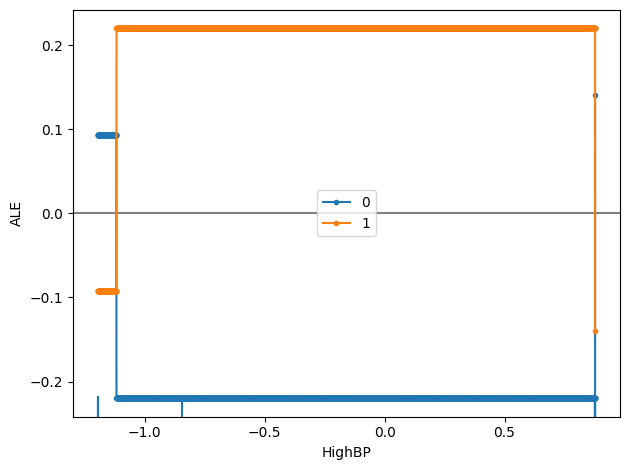

In [49]:
plot_ale(proba_exp_xgb_model, features=[0]);

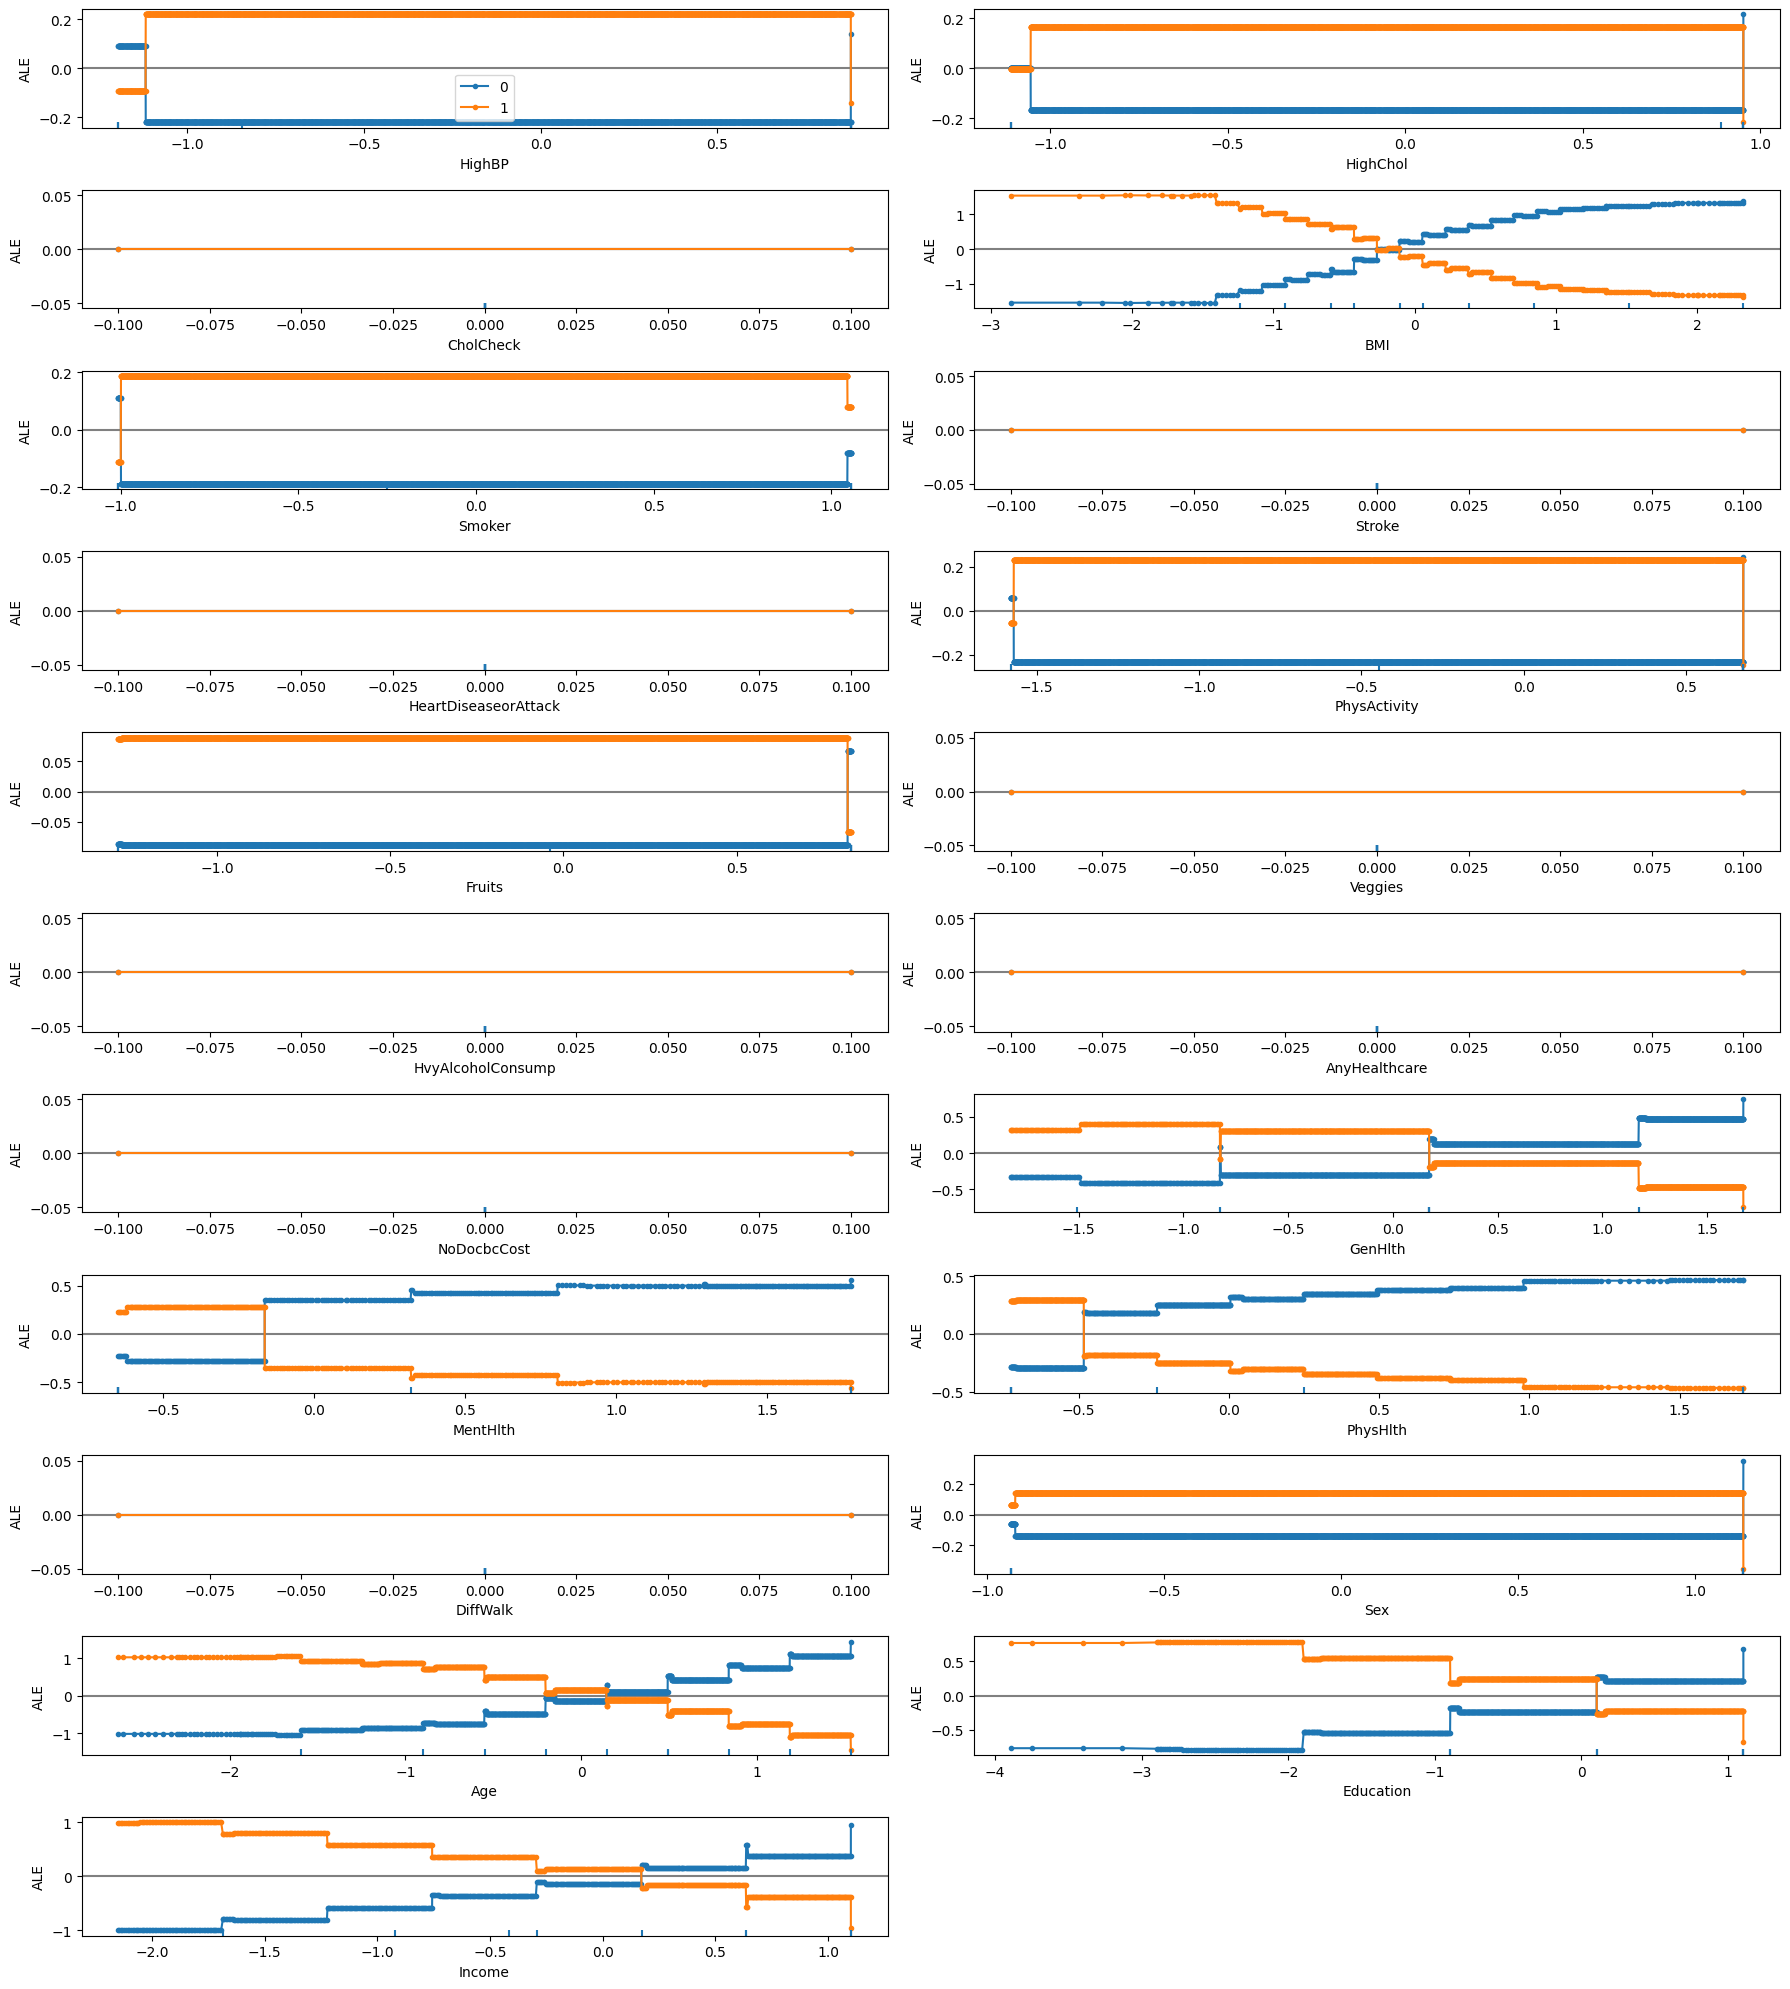

In [54]:
plot_ale(proba_exp_xgb_model, n_cols=2, fig_kw={'figwidth': 18, 'figheight': 20}, sharey=None);